IMPORTING LIBRARIES AND READING DATASET

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling
plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams['axes.grid'] = True
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
dataset=pd.read_csv('bankloans.csv')
len(dataset)

850

SUMMARY OF DATASET, IMPUTATIONS,CLIPPING

In [3]:

def overview(z):
    return pd.Series([z.count(), z.isnull().sum(), z.sum(), z.mean(), z.median(),  z.std(), z.var(), z.min(),z.max()], 
                  index=['Count', 'Defaulters', 'Sum', 'Mean','Median', 'Standard deviation', 'Variance', 'Minimum','Maximum'])


def categorical_overview(z):
    return pd.Series([z.count(), z.isnull().sum(), z.value_counts()], 
                  index=['Count', 'Defaulters', 'Column Names'])

def c_dum( v, cn ):
    new_c = pd.get_dummies(v[cn], prefix=cn)
    new_c.drop(new_c.columns[0], axis=1, inplace=True)
    v = pd.concat([v, new_c], axis=1)
    v.drop( cn, axis = 1, inplace = True )
    return v


def imputation_out(z):
    z = z.clip(upper=z.quantile(0.99))
    z = z.clip(lower=z.quantile(0.01))
    return z

def impt_miss(z):
    z = z.fillna(z.mean())
    return z

dataset.apply(lambda z: overview(z)).T



,Count,Defaulters,Sum,Mean,Median,Standard deviation,Variance,Minimum,Maximum
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,1.00000


In [4]:

ble = dataset[dataset.default.isnull()==0]
bln = dataset[dataset.default.isnull()==1]
ble=ble.apply(lambda z: imputation_out(z))
ble=ble.apply(lambda z: impt_miss(z))

HEATMAP

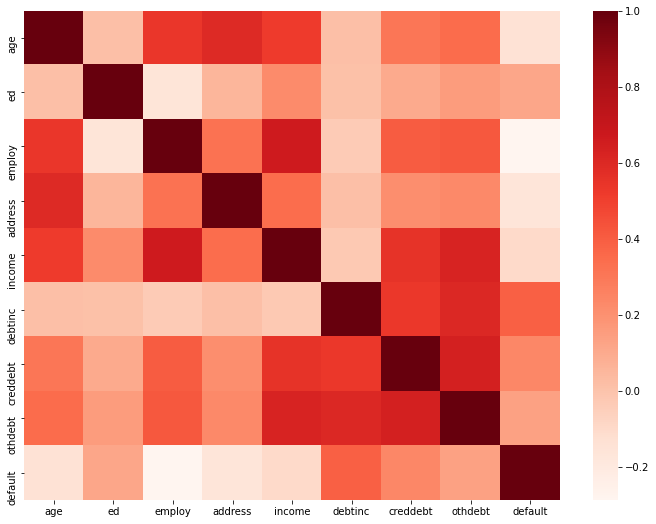

In [5]:

nuvm=[i for i in dict(dataset.dtypes) if dict(dataset.dtypes)[i] in ['float64', 'int64', 'float32', 'int32']]
cvna=[j for j in dict(dataset.dtypes) if dict(dataset.dtypes)[j] in ['object']]
sns.heatmap(ble.corr(), cmap='Reds')

BOXPLOT

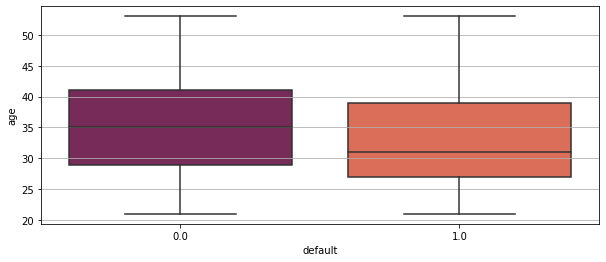

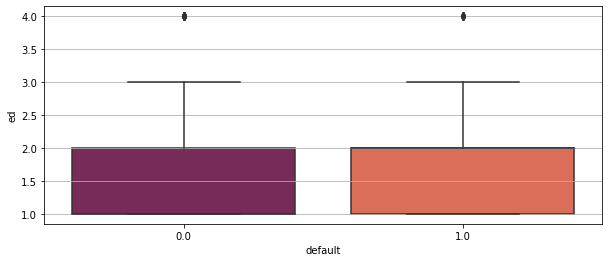

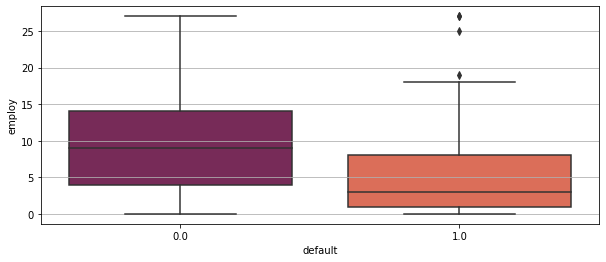

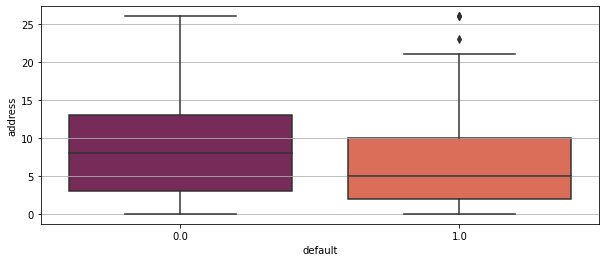

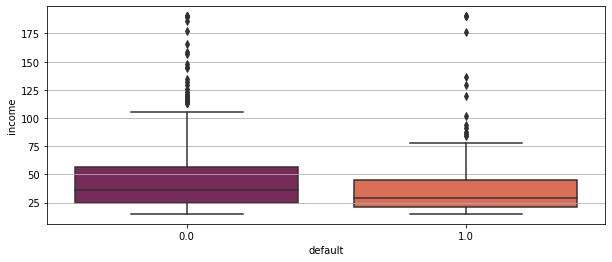

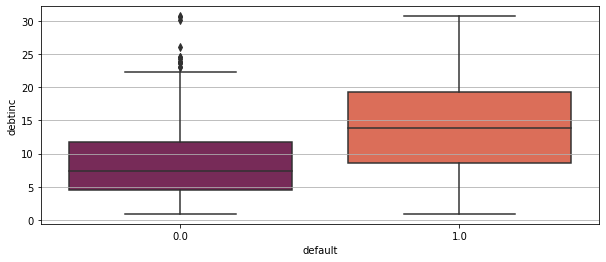

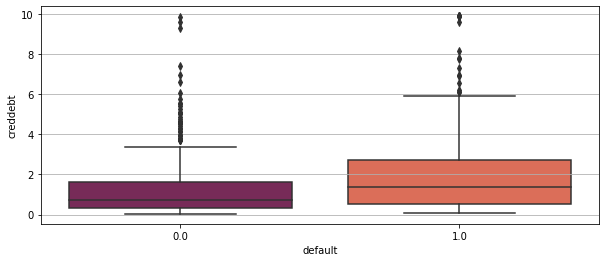

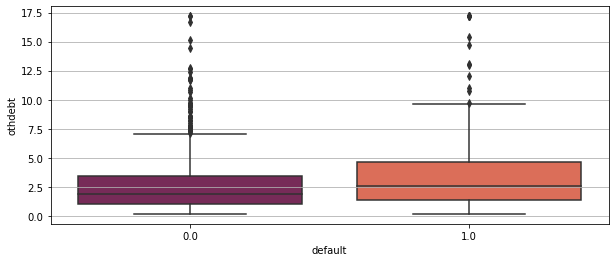

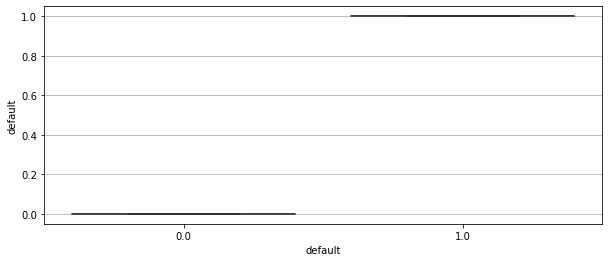

In [6]:
first = PdfPages('BPS.pdf')

for nv in nuvm:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=nv, data = ble, palette='rocket')
    first.savefig(fig)
first.close()

DISTPLOT

C:\Users\mmouk\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\mmouk\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


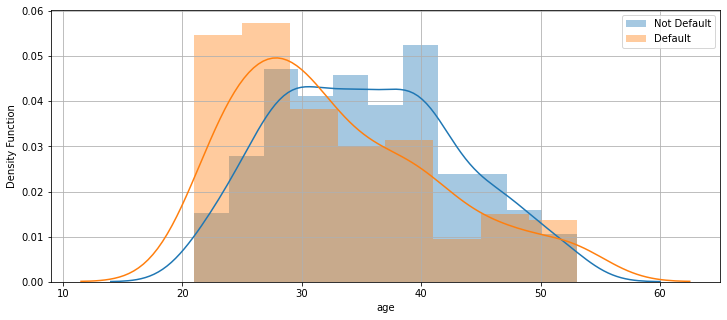

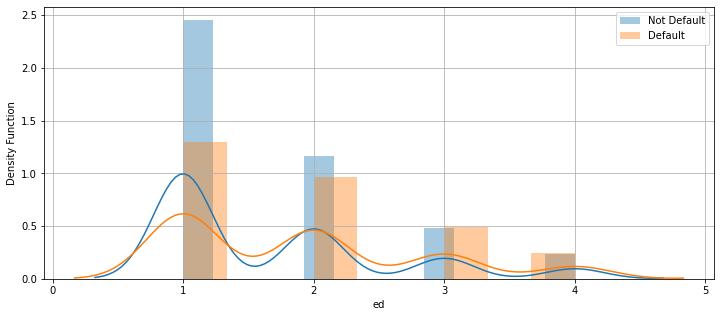

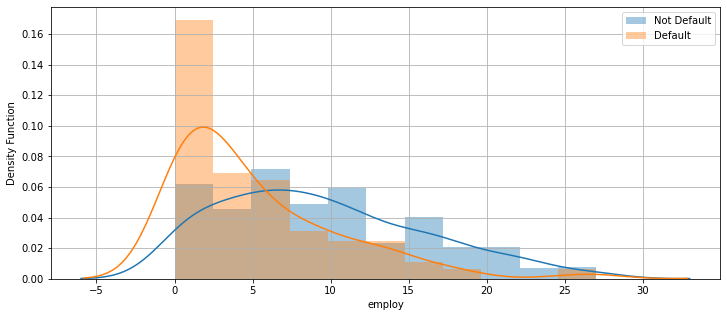

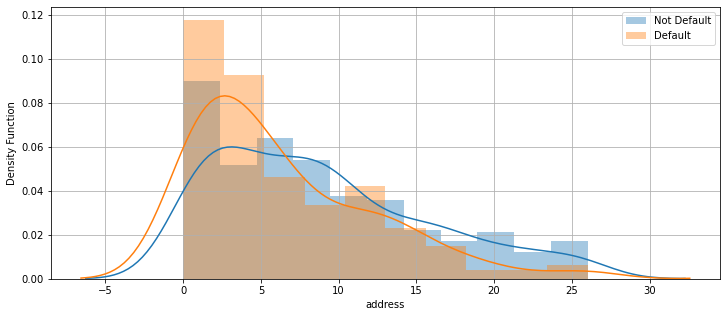

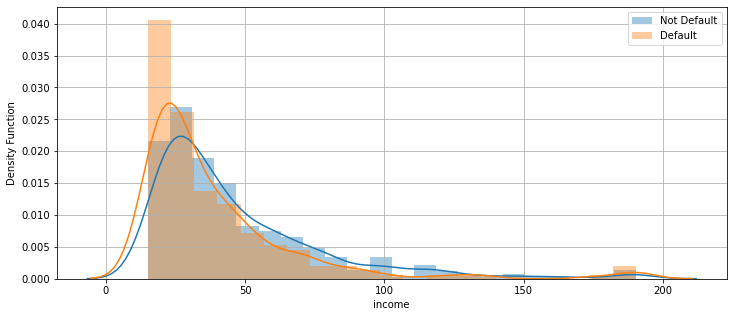

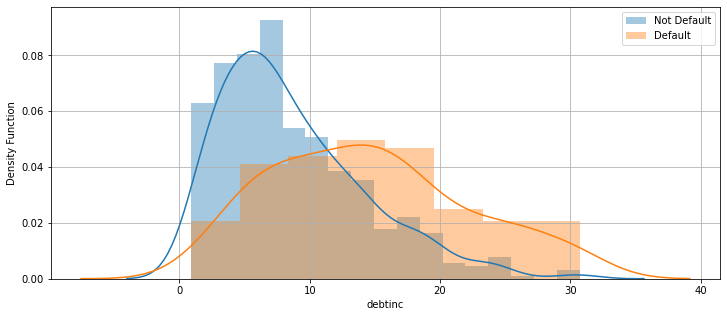

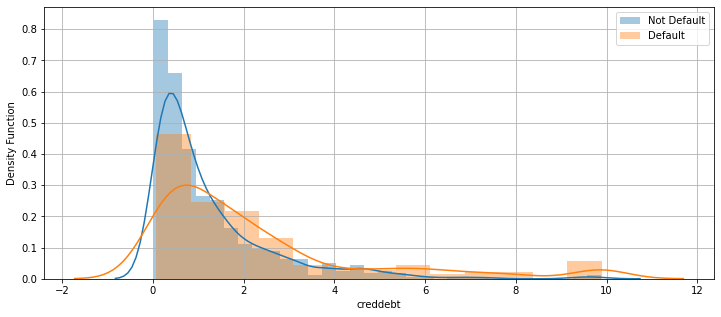

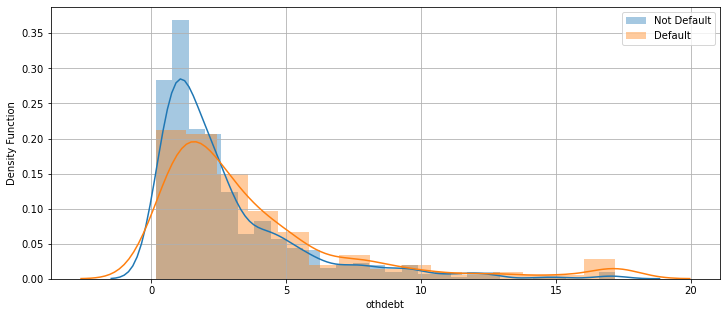

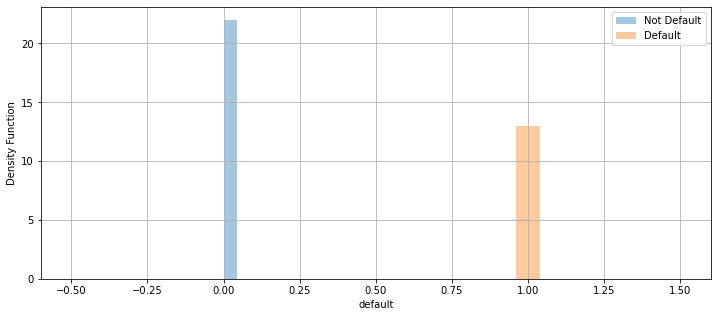

In [7]:
for nv in nuvm:
    fig,axes = plt.subplots(figsize=(12,5))

    sns.distplot(ble[ble['default']==0][nv], label='Not Default',hist=True, norm_hist=False)
    sns.distplot(ble[ble['default']==1][nv], label='Default',hist=True, norm_hist=False)
    plt.xlabel(str(nv))
    plt.ylabel('Density Function')
    plt.legend()
    

T-TEST

In [8]:
tsd = pd.DataFrame()
for nv in ble.columns.difference(['default']):
    ts=stats.ttest_ind(ble[ble.default==1][nv],ble[ble.default==0][nv])
    o = pd.DataFrame([nv, ts[0], ts[1]]).T
    o.columns = ['Var_Name', 'T_Stat', 'P_Val']
    tsd = pd.concat([tsd, o], axis=0, ignore_index=True)
print(tsd)

   Var_Name   T_Stat        P_Val
0   address -4.43055  1.09104e-05
1       age -3.69893  0.000233527
2  creddebt  6.47909   1.7428e-10
3   debtinc  11.1409  1.20241e-26
4        ed  3.15351   0.00168236
5    employ -7.92136  9.27995e-15
6    income -2.64329   0.00839468
7   othdebt   3.7073  0.000226095


VIF

In [9]:
ft = "+".join(ble.columns.difference(['default']))
c,d = dmatrices(formula_like='default ~ '+ ft, data = ble, return_type='dataframe')
vf = pd.DataFrame()
vf["VIF"] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
vf["Column Name"] = d.columns
print(vf)

         VIF Column Name
0  36.910987   Intercept
1   1.561802     address
2   2.037593         age
3   2.628899    creddebt
4   3.910509     debtinc
5   1.287345          ed
6   2.401544      employ
7   5.121585      income
8   4.562072     othdebt


LOGISTIC REGRESSION USING STATISTICAL MODEL 
i) CREATING MODEL

In [10]:
trf = ble.columns.difference(['default'])
trx, tx = train_test_split(ble, test_size=0.3, random_state=42)
trx.columns
lr = sm.logit(formula='default ~ ' + "+".join(trf), data=trx)
rs = lr.fit()

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


ii) AUC, GINI

In [11]:
cur = metrics.roc_auc_score(trx['default'], rs.predict(trx))
print('Area Under Curve is : ' + str(cur))
trg = 2*metrics.roc_auc_score(trx['default'], rs.predict(trx)) - 1
print("The Gini Index for Train Data Model : ", trg)
teg = 2*metrics.roc_auc_score(tx['default'], rs.predict(tx)) - 1
print("The Gini Index for Test Data model : ", teg)


Area Under Curve is : 0.8408309575716921
The Gini Index for Train Data Model :  0.6816619151433843
The Gini Index for Test Data model :  0.7665103308404106


iii) TRAINING MODEL

In [12]:
trpp = pd.DataFrame(rs.predict(trx))
trpp.columns = ['prob']
tra = trx['default']
trpre = pd.concat([tra, trpp], axis=1)
trpre.columns = ['actual','prob']
tepp = pd.DataFrame(rs.predict(tx))
tepp.columns = ['prob']
tea = tx['default']
tepre = pd.concat([tea, tepp], axis=1)
tepre.columns = ['actual','prob']
def cutoff(rs,trx,trpre):
    
    rldf = pd.DataFrame()
    trt = trpre.copy()

    for c in np.linspace(0,1,50):
        trt['c'] = c
        trt['predicted'] = trt['prob'].apply(lambda z: 0.0 if z < c else 1.0)
        trt['tp'] = trt.apply(lambda z: 1.0 if z['actual']==1.0 and z['predicted']==1 else 0.0, axis=1)
        trt['fp'] = trt.apply(lambda z: 1.0 if z['actual']==0.0 and z['predicted']==1 else 0.0, axis=1)
        trt['tn'] = trt.apply(lambda z: 1.0 if z['actual']==0.0 and z['predicted']==0 else 0.0, axis=1)
        trt['fn'] = trt.apply(lambda z: 1.0 if z['actual']==1.0 and z['predicted']==0 else 0.0, axis=1)
        sen = trt['tp'].sum() / (trt['tp'].sum() + trt['fn'].sum())
        spf = trt['tn'].sum() / (trt['tn'].sum() + trt['fp'].sum())
        rlt = pd.DataFrame([c, sen, spf]).T
        rlt.columns = ['cutoff', 'sensitivity', 'specificity']
        rldf = pd.concat([rldf, rlt], axis=0)
    return rldf

rldf = cutoff(rs,trx,trpre)

iv) CUT-OFF PROBABILITY, SENSITIVITY, SPECIFICITY

In [13]:
rldf['total'] = rldf['sensitivity'] + rldf['specificity']
rldf[rldf['total']==rldf['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.22449,0.880597,0.660112,1.540709


iv) CONFUSION MATRICES

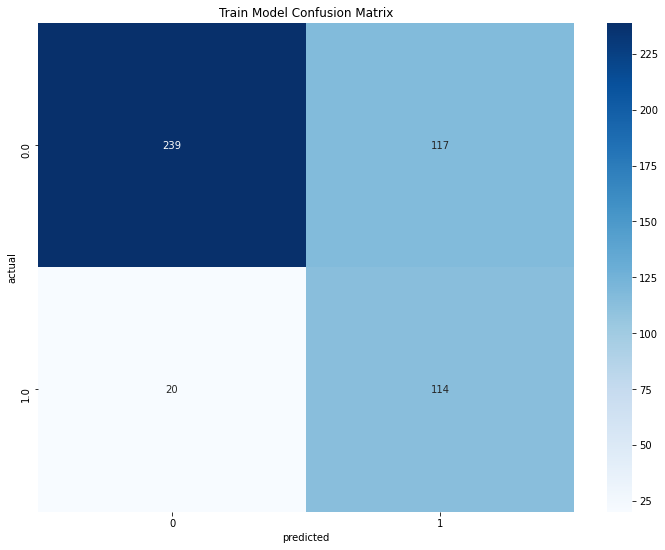

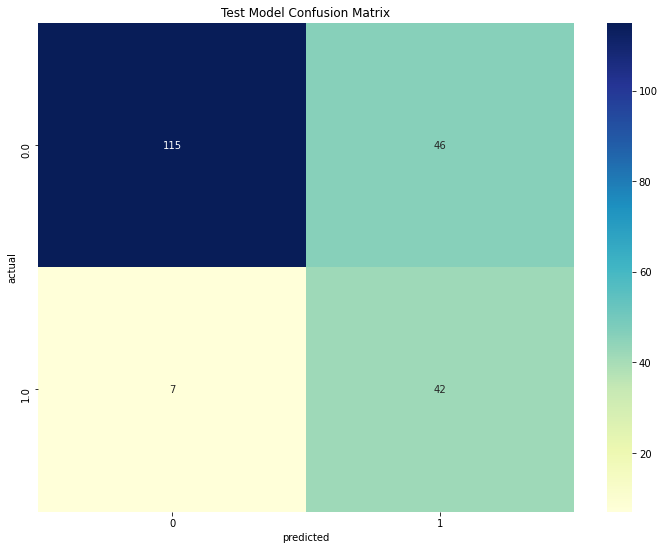

In [14]:
trpre['predicted'] = trpre['prob'].apply(lambda z: 1 if z > 0.24 else 0)
sns.heatmap(pd.crosstab(trpre['actual'], trpre['predicted']), annot=True, fmt='.0f',cmap='Blues')
plt.title('Train Model Confusion Matrix')
plt.show()

tepre['predicted'] = tepre['prob'].apply(lambda z: 1 if z > 0.24 else 0)
sns.heatmap(pd.crosstab(tepre['actual'], tepre['predicted']), annot=True, fmt='.0f',cmap='YlGnBu')
plt.title('Test Model Confusion Matrix')
plt.show()


iv)ACCURACY

In [15]:
print("Accuracy of Train model: ", metrics.accuracy_score(trpre.actual, trpre.predicted))
print("Accuracy of Test model: ", metrics.accuracy_score(tepre.actual, tepre.predicted))

Accuracy of Train model:  0.7204081632653061
Accuracy of Test model:  0.7476190476190476


v) DECILE ANALYSIS 

In [16]:
trpre['Deciles']=pd.qcut(trpre['prob'],10, labels=False)
dec = trpre[['Deciles','actual']].groupby(trpre.Deciles).sum().sort_index(ascending=False)
dec

,Deciles,actual
Deciles,,
9,441,36.0
8,392,28.0
7,343,26.0
6,294,15.0
5,245,13.0
4,196,6.0
3,147,5.0
2,98,3.0
1,49,2.0


LOGISTIC REGRESSION USING SKLEARN

i) CREATING, TRAINING MODEL

In [17]:
trf = ble.columns.difference(['default'])
trskx,teskx, trsky,tesky = train_test_split(ble[trf],ble['default'], test_size=0.3, random_state=42)
trskx.columns
lrgr = LogisticRegression()
lrgr.fit(trskx, trsky)
trp = pd.DataFrame({'actual':trsky,'predicted':lrgr.predict(trskx)})
trp = trp.reset_index()
trp.drop(labels='index',axis=1,inplace=True)
prpdf = pd.DataFrame(lrgr.predict_proba(trskx))
hrp = pd.concat([trp,prpdf],axis=1)
hrp.columns=['actual','predicted','Left_0','Left_1']

ii) GINI

In [18]:
trg = 2*metrics.roc_auc_score(trsky, lrgr.predict(trskx))-1
print("The Gini Index for Train Data model : ", trg)

teg = 2*metrics.roc_auc_score(tesky, rs.predict(teskx))-1
print("The Gini Index for Test Data model: ", teg)

The Gini Index for Train Data model :  0.3830706020459498
The Gini Index for Test Data model:  0.7665103308404106


ii) AUC

In [19]:
aus = metrics.roc_auc_score( hrp.actual, hrp.Left_1)
print("Area under the curve is: ", round( float( aus ),2))

Area under the curve is:  0.84


ii) ROC Curve

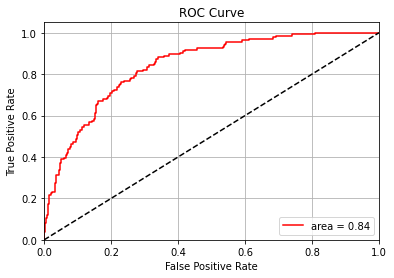

In [20]:

ftp, tabp, thresholds = metrics.roc_curve( hrp.actual,hrp.Left_1,drop_intermediate=False )
plt.figure(figsize=(6, 4))
plt.plot( ftp, tabp, label='area = %0.2f' % aus, color='r' )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

ii) CUT-OFF PROBABILITY

In [21]:
cpr = thresholds[(np.abs(tabp - 0.72)).argmin()]
hrp['new_labels'] = hrp['Left_1'].map( lambda z: 1 if z >= cpr else 0 )
print("Cutoff probability: ",cpr)

Cutoff probability:  0.372483365006753


iii) ACCURACY

In [22]:
print("Accuracy for Train Data using sklearn is : ", metrics.accuracy_score(trsky, lrgr.predict(trskx)))
print("Accuracy for Test Data using sklearn is: ", metrics.accuracy_score(tesky, lrgr.predict(teskx)))

Accuracy for Train Data using sklearn is :  0.7918367346938775
Accuracy for Test Data using sklearn is:  0.8571428571428571
